## Presentation

* 量子计算是当前的热点方向，离子阱平台是实现量子计算的可行方案之一。
* 目前的实验条件能够做到稳定囚禁几十个离子，但只能对其中少数几个离子做到精确的控制，即通过激光寻址让激光准确地打在这些离子上。
* 在未来，为了发挥量子计算的优势，我们需要扩大量子比特的规模，其中的一种技术方案就是qccd技术
<!-- ![qccd](images\qccd.png) -->
<img src="images\qccd.png" alt="drawing" width="200"/>\
* 该方案将离子阱分为存储区和作用区，存储区用于囚禁位于特定量子态的离子，作用区用于发生光与原子相互作用，即运行量子逻辑门
* 本工作就是基于新一代分段电极线性离子阱，设计输运路径和电压，以实现“好的”离子输运
  * 在输运过程中，离子不能偏离rf零点
  * 由于离子的谐振子态也储存了信息，在输运过程中我们不能让离子获得过多的能量，即*低加热率*
* 为了达成目标，我们分两步走
  * 将离子囚禁在指定位置，需要施加什么样的电压？
  * 为了降低加热率，我们应该让离子以怎样的速度输运？（准静态输运 or STA）


## 初始化

In [2]:
from potential_initialization import *
from trap_model import *
%load_ext autoreload
%autoreload 2

In [29]:
# 缓存pseudo potential在一个字典中，若在调试时修改了trap_model的定义可以快速初始化
pbi= dict()

In [30]:
# 设置需要计算势场的区域
shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.2]]
stepsize = 0.01
# rf电压和频率需要提前设置
V_rf = 170
omega_rf = 2 * np.pi * 30e6
# 初始化trap_model类型
junction = trap_model("junction", V_rf, omega_rf, shuttle_range, stepsize, pbi, regenerate=False)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

## 电极的编号、分区及可视化

In [ ]:
# 高亮编号为[0]的电极，即rf电极
junction.plot(part_id=[0])

In [ ]:
# 高亮名称为R-0和R-11的两对电极
junction.plot(electrodode=['R-3', 'R-4', "R-5"])

In [ ]:
#高亮1、8两个区域的电极
junction.plot(sector=[1, 8])

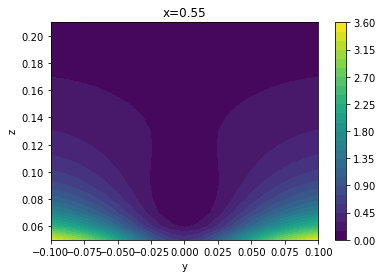

In [ ]:
# 也可以在使用过程中重新设置rf参数
junction.reset_rf(V_rf=170, omega_rf=omega_rf)
# 计算在dc电压全部为0的时候，x=0.55mm的势场截面
junction.plot_slice(voltage=np.zeros(94), x=0.55)

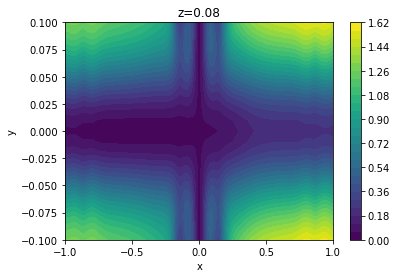

In [ ]:
# 计算在第1、8区域的电极电压为1V，其余dc电极电压为0V时，z=0.55mm的势场截面
indices = junction.get_indices(use_seconstantsors=[1,8])
voltage = np.zeros(94)
voltage[indices] = 1
junction.reset_rf(V_rf=170, omega_rf=omega_rf)
junction.plot_slice(voltage, z=0.08)

## 单一位置单个离子操作

d:\Anaconda\lib\site-packages\ndsplines\ndsplines.py:201: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)


0.061241298563103744

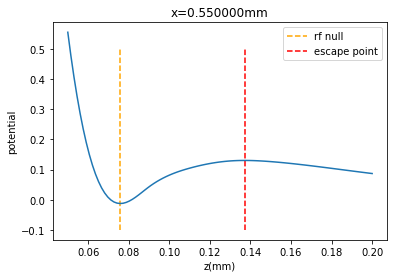

In [ ]:
# 求x=0.55时的阱深
junction.depth_of_trap(0.55, True)

In [ ]:
# 在x=0.4时rf零点的坐标，
rf_null = junction.rf_null_point(x=0.4)
# 初始化 电极配对、dc接地电极偏置 情况下的电极分组情况
base_gc = junction.base_gc(paired=True, ground_bias=True)
# 找到距离目标点最近的三对电极（以及dc接地电极）
gc = junction.top_nearest(rf_null, 3, base_gc)
# 将离子束缚在该位置需要如何设置电压
voltage = junction.optimize_voltage(x=0.4, gc=gc)

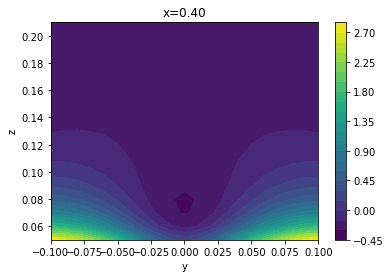

In [ ]:
junction.plot_slice(voltage, x=0.4)

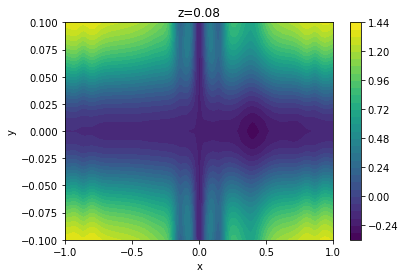

In [ ]:
junction.plot_slice(voltage, z=0.076)

In [ ]:
# 将上述电压带入，计算实际的势能最低点，这里不一样的原因是优化时还需要考虑二阶导
point = junction.position(voltage, 0.4)
point

array([[3.99976846e-01, 7.73032413e-05, 7.53114136e-02]])

In [ ]:
# 在该点处的电场强度大小
junction.electric_field(voltage, point)

array([7.16923565e-05, 4.09935941e-03, 3.96440428e-03])

In [ ]:
# 在势能最低点，简正模式(方向)和简正频率
junction.freq(point, voltage, rotate=True)

(array([0.48871191, 2.76831947, 2.80481106]),
 array([[-9.99942495e-01, -1.07112323e-02, -5.26109326e-04],
        [-2.99824694e-04, -2.11165749e-02,  9.99776975e-01],
        [ 1.07199530e-02, -9.99719641e-01, -2.11121491e-02]]))

## 单一位置多个离子操作

In [ ]:
# 粗略估计两个离子之间距离的数量级
f=1*np.pi*1e6
alpha0 = f**2*m/q
alpha = junction.hess_at_point(voltage, point)[0, 0] * 1e6
d = (2*q/alpha/4/np.pi/eps0) ** (1 / 3)
d, alpha, alpha0
# 离子间的距离在5微米左右

(5.48236828999659e-06, 17453670.13745683, 17521826.750272844)

In [ ]:
# 用这样的电压设置在x=0.4处囚禁5个离子
points = junction.position(voltage, 0.4, 5)
points
# 坐标的单位是mm

array([[3.92380632e-01, 7.49197476e-05, 7.53974664e-02],
       [3.96399648e-01, 7.62255081e-05, 7.53504009e-02],
       [3.99986830e-01, 7.73232385e-05, 7.53111009e-02],
       [4.03575995e-01, 7.83509709e-05, 7.52743628e-02],
       [4.07601808e-01, 7.94753157e-05, 7.52361994e-02]])

In [ ]:
print("rf零点的理论位置\n", rf_null)
print("囚禁单个离子\n", point)
# 这说明按照向量最小二乘并不能把离子囚禁在我们想要的位置，或许需要加大一阶项的权重
print("用囚禁单个离子的电压设置囚禁5个离子\n", points)
# 两个离子的间距在 1e-3mm 量级


rf零点的理论位置
 [ 4.0000000e-01 -1.1594750e-05  7.5310857e-02]
囚禁单个离子
 [[3.99976834e-01 7.73022979e-05 7.53114140e-02]]
用囚禁单个离子的电压设置囚禁5个离子
 [[3.92380696e-01 7.49145063e-05 7.53974658e-02]
 [3.96399613e-01 7.62076094e-05 7.53504053e-02]
 [3.99986849e-01 7.73059024e-05 7.53110954e-02]
 [4.03576021e-01 7.83614134e-05 7.52743563e-02]
 [4.07601789e-01 7.94715793e-05 7.52362001e-02]]


## 离子输运

In [97]:
# junction.reset_rf(V_rf=170, omega_rf=omega_rf)
# 输运的方向沿x方向，由x=0.4到x=0.7
x_initial = 0.4
x_final = 0.6
N_seg = 50
profile = np.linspace(x_initial, x_final, N_seg)
# alpha是电压随离子坐标的变化率上限，单位V/mm
# alpha * 输运速度 = 电压对时间的变化率上限
# w是权重向量
# omega表示三个方向的目标阱频，单位MHz
# max_voltage表示在优化过程中电压的上限
# confine_voltage表示非临近电极的电压值
# calc_position 表示是否返回离子在各个时间点的平衡位置

  0%|          | 0/50 [00:00<?, ?it/s]

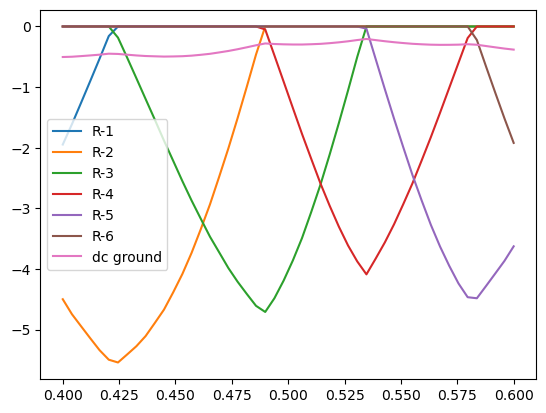

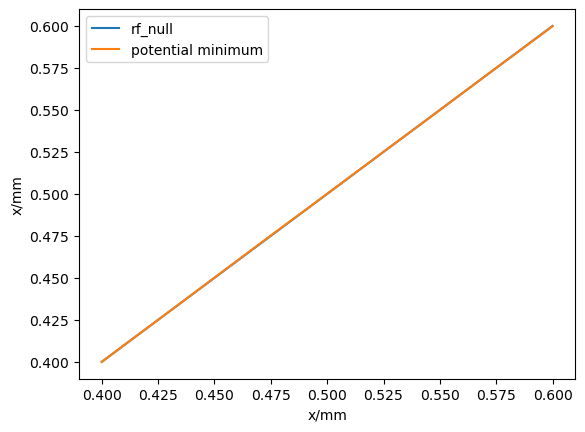

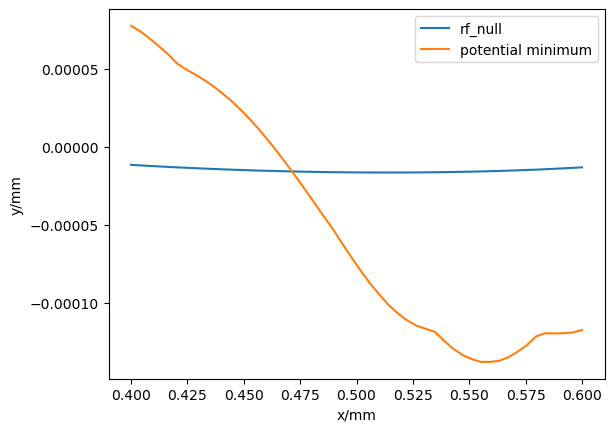

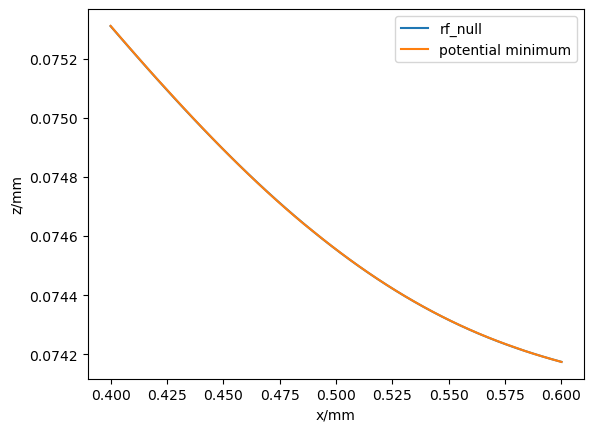

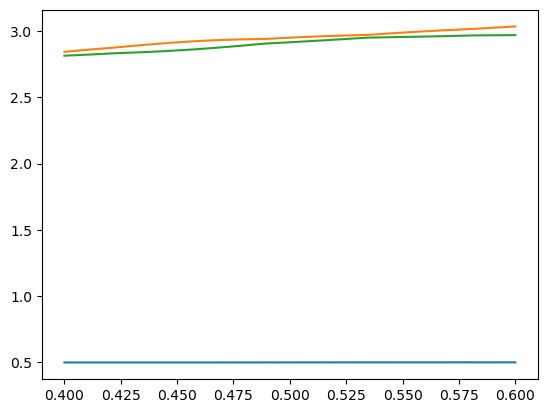

In [99]:
volts = junction.optimize_voltage_profile(profile, plot=True, w=[0, 100, 0, 1000, 1, 0.001, 0.001, 0, 0.0005, 0, 0, 0])

## 离子运动的经典模拟

In [ ]:
omega = 5e5*2*np.pi
(2*constants.hbar/m/omega)**0.5

1.5373697536009558e-08

离子运动的特征长度是
$$
x=\sqrt{\frac{2\hbar}{m\omega}}\approx15nm
$$





In [ ]:
x=4e-7
omega=5e5*2*np.pi
m*omega*x**2/constants.hbar

1353.92096567823

In [ ]:
from shuttle_protocols import qsin, const_speed, qsta2
T = 1e-4
Th = 1e-5
# 对应的输运速度是3m/s
q0_of_t, tspan, y = junction.transport_motion(T, x_initial, x_final, volts, N_ions=1, Th=Th, protocol=const_speed)

In [ ]:
quanta = constants.hbar * 5e5 * 2*np.pi
quanta

3.313035075e-28

Text(0, 0.5, 'x/mm')

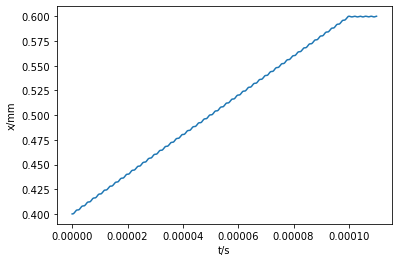

In [ ]:
plt.plot(tspan, y[0])
plt.xlabel("t/s")
plt.ylabel("x/mm")

In [ ]:
ideal_x = junction.rf_null_point(y[0])

蓝色是实际轨迹中离子的z坐标随时间的变化\
橙色是根据离子x坐标求当对应的rf零点所在的高度，可以看到离子输运过程中高于rf零点的问题被基本解决

Text(0, 0.5, 'z/mm')

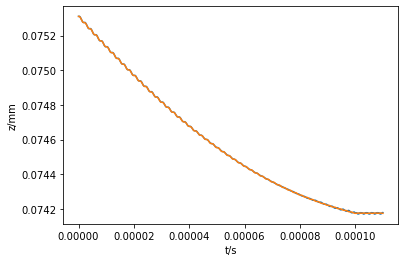

In [ ]:
plt.plot(tspan, y[2])
plt.plot(tspan, ideal_x[:, 2])
plt.xlabel("t/s")
plt.ylabel("z/mm")

In [ ]:
heating = junction.heating_one_ion(q0_of_t, tspan, T, y)
heating

468.3539413366676

## STA

In [45]:
from shuttle_protocols import qsin, const_speed, qsta2, qsta
T = 1e-4
q0_of_t, tspan, y = junction.transport_motion(T, x_initial, x_final, volts, N_ions=1, protocol=qsta2)

1.3566324214441439

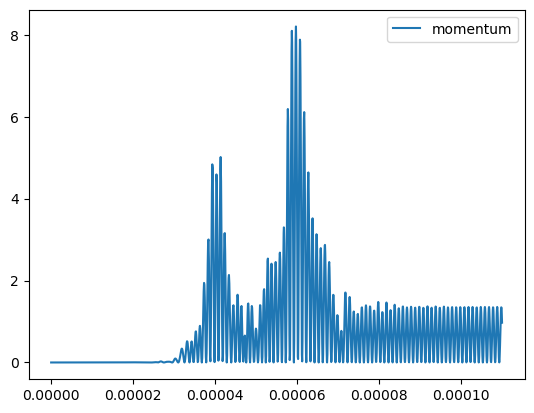

In [46]:
heating = junction.heating_one_ion_during_transportation(q0_of_t, tspan, y.transpose())
heating = junction.heating_one_ion(q0_of_t, tspan, T, y)
heating

1.3566324214441439

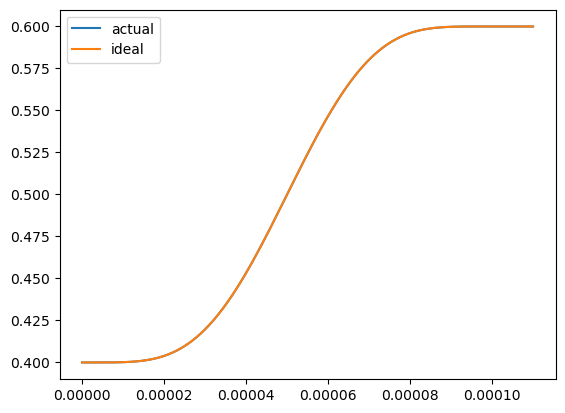

In [47]:
plt.plot(tspan, y[0], label='actual')
plt.plot(tspan, [q0_of_t(t)for t in tspan], label='ideal')
plt.legend()
heating = junction.heating_one_ion(q0_of_t, tspan, T, y)
heating

## 如何主轴旋转特定角度（尚未完成）

In [ ]:
# 如果发生主轴旋转，假设我们想要x方向仍为主轴，yz方向旋转45度，则先定义旋转矩阵
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

# 绕x轴旋转pi/4
R = M([1, 0, 0], np.pi / 4)

# 若电极配对，则无法完成旋转，故此处paired=False，用最近的8个电极，将生成的旋转矩阵导入，进行优化

w = [0, 1, 1, 1, 1, 1, 1, 10, 10, 10] # 权重需要重新调整

voltage = junction.optimize_voltage(x=0.56, top_nearest=8, max_voltage=10, w=w, rotation=R)

TypeError: optimize_voltage() got an unexpected keyword argument 'top_nearest'

In [ ]:
# 优化还存在问题，显然没有找到最优解

junction.freq(point, voltage, True)

(array([0.48871191, 2.76831947, 2.80481106]),
 array([[-9.99942495e-01, -1.07112323e-02, -5.26109326e-04],
        [-2.99824694e-04, -2.11165749e-02,  9.99776975e-01],
        [ 1.07199530e-02, -9.99719641e-01, -2.11121491e-02]]))

## Splitting 离子链的分离

In [56]:
import shuttle_protocols

In [70]:
omega = np.array([0.5, 3, 3])
k = (m / q * (omega*1e6 * 2 * np.pi) ** 2) * 1e-6
k

array([ 17.52182675, 630.78576301, 630.78576301])

In [63]:
shuttle_protocols.split_sta(0)

(7.098804704953337e-08, -1.3228908361642219e-11)

In [ ]:
# 在x=0.4时rf零点的坐标，
rf_null = junction.rf_null_point(x=0.5)
# 初始化 电极配对、dc接地电极偏置 情况下的电极分组情况
base_gc = junction.base_gc(paired=True, ground_bias=True)
# 找到距离目标点最近的三对电极（以及dc接地电极）
gc = junction.top_nearest(rf_null, 5, base_gc)

junction.optimize_voltage('split', 0.5, gc, w=[],
                          alpha=, beta=)

In [101]:
f0 = 5e5*2*np.pi
s=0
mass = 171 * constants.atomic_mass
eps0 = constants.epsilon_0
K = constants.e**2/(4*np.pi*eps0)
_a10, _a11 = -780, 127
a0 = 0.5*mass*f0**2
print(a0/constants.e*1e-6)
l0 = 2*a0/mass*np.array([1, 3]) ## (-, +)
lf = 2*a0/mass*np.array([1, 1.002])
gp, gm = (l0/lf)**0.25
rho_m_t = lambda s, a10=_a10, a11=_a11: 1-(126*(1-gm) + a10 + 5*a11)*s**5 + (420*(1-gm) + 5*a10 + 24*a11)*s**6 - (540*(1-gm) + 10*a10 + 45*a11)*s**7 + (315*(1-gm) + 10*a10 + 40*a11)*s**8 - (70*(1-gm) + 5*a10 + 15*a11)*s**9 + a10*s**10 + a11*s**11
    
rho_m = rho_m_t(s)
d2rho_pdt2 = derivative(rho_m_t, s, n=2)
lm_t = l0[1]*rho_m**(-4) - d2rho_pdt2/rho_m
lp_t = l0[0]
print(lm_t**0.5, (lp_t/lm_t))
d_ideal = (4*K/(mass*(lm_t-lp_t)))**(1/3) ## SI units [m]
a_ideal = (mass/8*(3*lm_t - 5*lp_t)) ## SI units [V/m^2]
b_ideal = (2*K*(d_ideal)**(-5) - 2*a_ideal*(d_ideal)**(-2)) ## SI units [V/m^4]
a_ideal*1e-6*2/constants.e, b_ideal*(1e-12)*24/constants.e, d_ideal

8.745901137833739
5441398.093545053 0.33333333323012465


C:\Users\TangGaoxiang\AppData\Local\Temp\ipykernel_17648\1198293408.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2rho_pdt2 = derivative(rho_m_t, s, n=2)


(17.491802287853293, -0.003245266924721377, 5.480864666336476e-06)

Text(0, 0.5, '$\\beta (V/mm^4)$')

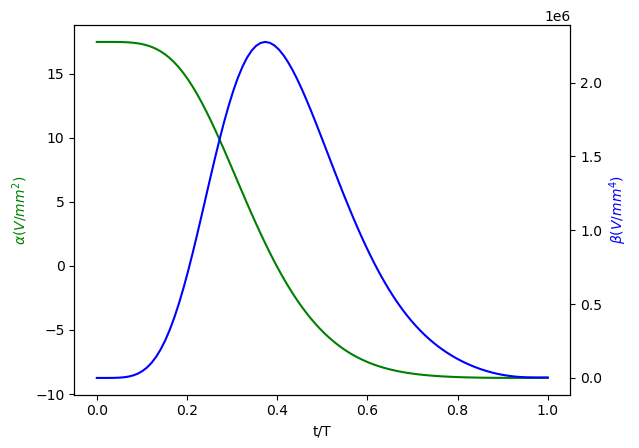

In [118]:
s = np.linspace(0, 1, 100)

a, b = shuttle_protocols.split_sta(s)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(s, a, 'g-')
ax2.plot(s, b, 'b-')

ax1.set_xlabel('t/T')
ax1.set_ylabel(r'$\alpha (V/mm^2)$ ', color='g')
ax2.set_ylabel(r'$\beta (V/mm^4)$', color='b')


In [136]:

point = junction.rf_null_point(0.4)
beta = junction.x_taylor(point)[:, 3]
arg = np.argsort(-np.absolute(beta))
beta[arg]

array([ 7.56897993e+02,  7.55625905e+02, -2.68537850e+02, -2.68450823e+02,
       -2.55122192e+02, -2.54349458e+02, -1.76817317e+02, -1.11519364e+02,
       -1.09438589e+02, -7.45067325e+01,  7.38664611e+01, -7.35548531e+01,
        7.27847669e+01, -4.44782384e+01, -3.13597577e+01, -3.11112299e+01,
       -1.53886496e+01, -1.52591453e+01,  1.47069047e+01,  1.43210205e+01,
        1.17221171e+01,  1.15448047e+01, -8.77150569e+00, -8.67745098e+00,
        8.49516606e+00,  8.47090008e+00,  6.04755948e+00,  5.99704958e+00,
        3.02755339e+00,  3.01108457e+00,  2.60152168e+00,  1.92608829e+00,
        1.09814669e+00,  1.07960235e+00,  8.23666725e-01,  7.91505563e-01,
       -6.71852224e-01, -6.63904683e-01, -6.62676310e-01, -6.50093423e-01,
        6.26075498e-01,  6.09028164e-01,  6.02604406e-01,  5.72798348e-01,
       -5.26422042e-01, -5.20516153e-01, -4.96478526e-01, -4.81345438e-01,
       -4.37238212e-01, -4.33003955e-01, -4.06300798e-01, -4.03405446e-01,
        3.63392938e-01,  

In [141]:
d=4e-5
(12*constants.e/np.pi/eps0/d**5) *1e-12

674.9833818012031